In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools

In [10]:
# support functions
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [18]:
def mse(p, delta, n, m):
    q = p + delta
    nom = n*p*(1-p) + m*q*(1-q) + m**2*(p-q)**2
    denom = (n+m)**2
    return nom/denom

In [57]:
p = 0.5
delta_list = np.arange(0, 0.3+1e-3, 0.05)
n = 4
m_list = np.arange(0, 20, 0.1)

In [58]:
mse_list = []
for delta in delta_list:
    mse_delta = []
    for m in m_list:
        mse_delta.append(mse(p, delta, n, m))
    mse_list.append(mse_delta)
mse_list = np.array(mse_list)

Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta$')

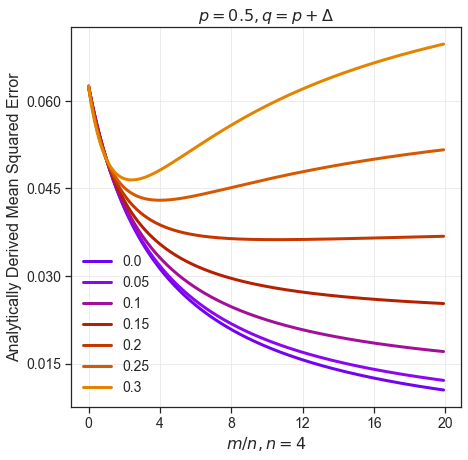

In [61]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.gnuplot(i) for i in np.linspace(0.2, 0.8, len(delta_list))]
for i, delta in enumerate(delta_list):
    ax.plot(m_list, mse_list[i], c=cmap[i], lw=3, label=str(np.round(delta, 2)))
ax.set_ylabel("Analytically Derived Mean Squared Error", fontsize=fontsize)
ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta$".format(p), fontsize=fontsize)

## Comparing the Hodges estimator with the naive and combined estimators

In [269]:
def get_teststat(p_hat, q_hat, n, m):
    nom = np.abs(p_hat - q_hat)
    p_bar = (n * p_hat + m * q_hat)/(n + m)
    denom = np.sqrt( p_bar * (1 - p_bar) * (1/n + 1/m) )
    return nom / denom

def compute_squared_error(p, p_hat, q_hat, n, m):
    T = get_teststat(p_hat, q_hat, n, m)
    p_bar = (n * p_hat + m * q_hat)/(n + m)
    mse_comb = (p_bar - p)**2
    mse_naive = (p_hat - p)**2
    mse = 0
    if T > 1.96:
        mse = mse_naive
    else:
        mse = mse_comb
    return mse_naive, mse_comb, mse

In [270]:
p = 0.5
delta_list = np.arange(0, 0.5+1e-3, 0.05)
n = 4
m_list = [8] #[4, 8, 12, 16, 20]
reps = 100000

In [271]:
p_hat_array = np.random.binomial(n, p, reps) / n

hodges_list = []
comb_list = []
for m in m_list:
    
    hodges_mse_list = []
    naive_mse_list = []
    comb_mse_list = []
    
    for delta in delta_list: 
        q = p + delta

        q_hat_array = np.random.binomial(m, q, reps) / m

        f = lambda p_hat, q_hat : compute_squared_error(p, p_hat, q_hat, n, m)

        with tqdm_joblib(tqdm(desc="Compute Acc", total=reps)) as progress_bar:
            ses = np.array(Parallel(n_jobs=-1)(delayed(f)(p_hat_array[i], q_hat_array[i]) for i in range(reps)))
        
        mses = np.mean(ses, axis=0)
        naive_mse_list.append(mses[0])
        comb_mse_list.append(mses[1])
        hodges_mse_list.append(mses[2])
        
    hodges_list.append(hodges_mse_list)
    comb_list.append(comb_mse_list)
    
hodges_list = np.array(hodges_list)   
naive_mse_list = np.array(naive_mse_list)
comb_list = np.array(comb_list)

Compute Acc:   0%|          | 1/100000 [00:01<35:19:28,  1.27s/it]/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
Compute Acc:   2%|▏         | 1802/100000 [00:01<00:53, 1819.26it/s]/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/gh/4z024hy17rnf9wmws7wgff6w0000gn/T/ipykernel_85615/3217954115.py:5: RuntimeWarning: invalid value encountered in double_scalars
/var/folders/g

Text(0.5, 1.0, '$p = 0.5, q = p + \\Delta, n = 4, m = 8$')

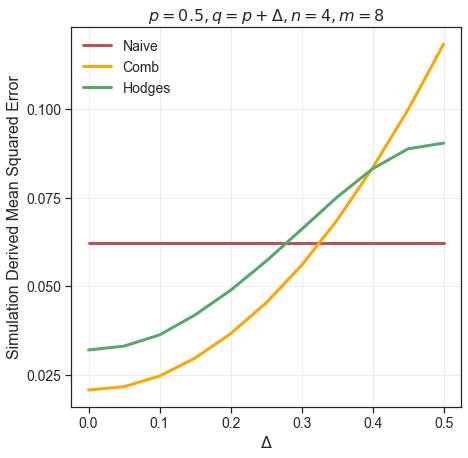

In [272]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(delta_list, naive_mse_list, c='r', lw=3, label="Naive")
ax.plot(delta_list, comb_list[0], c='orange', lw=3, label="Comb")
ax.plot(delta_list, hodges_list[0], c='g', lw=3, label="Hodges".format(m_list[0]))

ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta, n = {}, m = {}$".format(p, n, m_list[0]), fontsize=fontsize)

In [ ]:
fontsize = 16
labelsize = 14
fig, ax = plt.subplots(figsize=(7, 7))
cmap = [plt.cm.summer_r(i) for i in np.linspace(0.2, 0.8, len(m_list))]
for i in range(len(m_list)):
    ax.plot(delta_list, hodges_list[i], c=cmap[i], lw=3, label="Hodges (m = {})".format(m_list[i]))
ax.plot(delta_list, naive_mse_list, c='r', lw=3, label="Naive")
ax.set_ylabel("Simulation Derived Mean Squared Error", fontsize=fontsize)
# ax.set_xlabel(r"$m/n, n=4$", fontsize=fontsize)
ax.set_xlabel(r"$\Delta$", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.legend(fontsize=labelsize, frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.set_title(r"$p = {}, q = p + \Delta, n = {}$".format(p, n), fontsize=fontsize)